# Generative Adversarial Networks

Generative Adversarial Networks are invented by Ian Goodfellow (https://arxiv.org/abs/1406.2661).

"There are many interesting recent development in deep learning…The most important one, in my opinion, is adversarial training (also called GAN for Generative Adversarial Networks). This, and the variations that are now being proposed is the most interesting idea in the last 10 years in ML, in my opinion." – Yann LeCun

One network generates candidates and one evaluates them, i.e. we have two models, a generative model and a discriminative model. Before looking at GANs, let’s briefly review the difference between generative and discriminative models:
- A discriminative model learns a function that maps the input data (x) to some desired output class label (y). In probabilistic terms, they directly learn the conditional distribution P(y|x). 
- A generative model tries to learn the joint probability of the input data and labels simultaneously, i.e. P(x,y). This can be converted to P(y|x) for classification via Bayes rule, but the generative ability could be used for something else as well, such as creating likely new (x, y) samples.

The discriminative model has the task of determining whether a given image looks natural (an image from the dataset) or looks like it has been artificially created. The task of the generator is to create images so that the discriminator gets trained to produce the correct outputs. This can be thought of as a zero-sum or minimax two player game. Or Goodfellow describes it
"the generative model is pitted against an adversary: a discriminative model that learns to determine whether a sample is from the model distribution or the data distribution. The generative model can be thought of as analogous to a team of counterfeiters, trying to produce fake currency and use it without detection, while the discriminative model is analogous to the police, trying to detect the counterfeit currency. Competition in this game drives both teams to improve their methods until the counterfeits are indistiguishable from the genuine articles."

The generator is typically a deconvolutional neural network, and the discriminator is a convolutional neural network. Convolutional networks are a bottom-up approach where the input signal is subjected to multiple layers of convolutions, non-linearities and sub-sampling. By contrast, each layer in our Deconvolutional Network is top-down; it seeks to generate the input signal by a sum over convolutions of the feature maps (as opposed to the input) with learned filters. Given an input and a set of filters, inferring the feature map activations requires solving a multi-component deconvolution problem that is computationally challenging.

Here is a short overview of the process:

<img src="images/GAN.png">

What are the pros and cons of Generative Adversarial Networks?
- https://www.quora.com/What-are-the-pros-and-cons-of-using-generative-adversarial-networks-a-type-of-neural-network

Why are they important?
The discriminator now is aware of the “internal representation of the data” because it has been trained to understand the differences between real images from the dataset and artificially created ones. Thus, it can be used as a feature extractor that you can use in a CNN.

In [1]:
import numpy as np
from keras.datasets import mnist

import keras
from keras.layers import Input, UpSampling2D, Conv2DTranspose, Conv2D, LeakyReLU
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from tensorflow.examples.tutorials.mnist import input_data
from keras.layers.normalization import *
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

Using TensorFlow backend.


# MNIST database
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. 

The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. 

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Extracting mnist\train-images-idx3-ubyte.gz
Extracting mnist\train-labels-idx1-ubyte.gz
Extracting mnist\t10k-images-idx3-ubyte.gz
Extracting mnist\t10k-labels-idx1-ubyte.gz
60000 train samples
10000 test samples


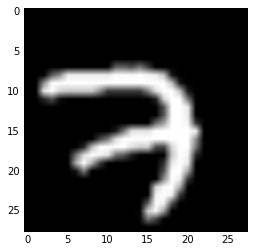

In [3]:
x_train = input_data.read_data_sets("mnist",one_hot=True).train.images
x_train = x_train.reshape(-1, 28,28, 1).astype(np.float32)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

pixels = x_train[0]
pixels = pixels.reshape((28, 28))
# Plot
plt.imshow(pixels, cmap='gray')

plt.show()


# Description of discriminator

As the discriminator network needs to differentiate between real and fake images the discriminator takes in  [1,28,28] image vectors. For this purpose several convolutional layers are used.

In [4]:
# Build discriminator
Dis = Sequential()
input_shape = (28,28,1)

#output 14 x 14 x 64
Dis.add(Conv2D(64, 5, strides = 2, input_shape = input_shape, padding='same'))
Dis.add(LeakyReLU(0.2))
Dis.add(Dropout(0.2))

#output 7 x 7 x 128
Dis.add(Conv2D(128, 5, strides = 2, input_shape = input_shape, padding='same'))
Dis.add(LeakyReLU(0.2))
Dis.add(Dropout(0.2))

#output 4 x 4 x 256
Dis.add(Conv2D(256, 5, strides = 2, input_shape = input_shape, padding='same'))
Dis.add(LeakyReLU(0.2))
Dis.add(Dropout(0.2))

#output 4 x 4 x 512
Dis.add(Conv2D(512, 5, strides = 1, input_shape = input_shape, padding='same'))
Dis.add(LeakyReLU(0.2))
Dis.add(Dropout(0.2))

# Out: 1-dim probability
Dis.add(Flatten())
Dis.add(Dense(1))
Dis.add(Activation('sigmoid'))

Dis.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________

# Description of generator

For the generator we generate 100 random inputs and eventually map them down to a [1,28,28] pixel so that the they have the same shape as the MNIST data. 
In Keras, for Deconvolution there is the command "Conv2DTranspose": Transposed convolution layer (sometimes called Deconvolution). The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.

In [5]:
#Build generator
g_input = Input(shape=[100])
Gen = Sequential()

Gen.add(Dense(7*7*256, input_dim=100,kernel_initializer="glorot_normal"))
Gen.add(BatchNormalization(momentum=0.9))
Gen.add(Activation('relu'))
Gen.add(Reshape((7, 7,256)))
#G.add(Dropout(0.2))
            
# Input 7 x 7 x 256
# Output 14 x 14 x 128
Gen.add(UpSampling2D())
Gen.add(Conv2DTranspose(int(128), 5, padding='same',kernel_initializer="glorot_normal"))
Gen.add(BatchNormalization(momentum=0.9))
Gen.add(Activation('relu'))

# Input 14 x 14 x 128
# Output 28 x 28 x 64
Gen.add(UpSampling2D())
Gen.add(Conv2DTranspose(int(64), 5, padding='same',kernel_initializer="glorot_normal"))
Gen.add(BatchNormalization(momentum=0.9))
Gen.add(Activation('relu'))

# Input 28 x 28 x 64
# Output 28 x 28 x 32
Gen.add(Conv2DTranspose(int(32), 5, padding='same',kernel_initializer="glorot_normal"))
Gen.add(BatchNormalization(momentum=0.9))
Gen.add(Activation('relu'))

# Out: 28 x 28 x 1 
Gen.add( Conv2DTranspose(1, 5, padding='same',kernel_initializer="glorot_normal"))
Gen.add( Activation('sigmoid'))

Gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_2 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
__________

In [6]:
# Discriminator model
optimizer = Adam(lr=0.0002, beta_1=0.5)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
DM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1)                 4311553   
Total params: 4,311,553
Trainable params: 4,311,553
Non-trainable params: 0
_________________________________________________________________


When training the GAN we are searching for an equilibrium point, which is the optimal point in a minimax game:
- The generator will models the real data, 
- and the discriminator will output probability of 0.5 as the output of the generator = real data

In [7]:
# Adversarial model
optimizer = Adam(lr=0.0002, beta_1=0.5)
AM = Sequential()
AM.add(Gen)
AM.add(Dis)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
AM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 6,680,258
Non-trainable params: 25,536
_________________________________________________________________


In [8]:
# Freeze weights in discriminator D for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val        
        
make_trainable(D, False)

The algorithm for training a GAN is the following:
1. Generate images using G and random noise (G predicts random images)
2. Perform a Batch update of weights in A given generated images, real images, and labels.
3. Perform a Batch update of weights in G given noise and forced “real” labels in the full GAN.
4. Repeat

In [9]:
train_steps=50000
batch_size=256 
noise_input = None

for i in range(train_steps):
    images_train = x_train[np.random.randint(0,x_train.shape[0], size=batch_size),:,:,:]
    noise = np.random.normal(0.0, 1.0, size=[batch_size, 100])
    images_fake = Gen.predict(noise)
    
    make_trainable(Dis, True)    
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0    
    d_loss = DM.train_on_batch(x, y)
    
    make_trainable(Dis, False)        
    y = np.ones([batch_size, 1])
    noise = np.random.normal(0.0, 1.0, size=[batch_size, 100])
    a_loss = AM.train_on_batch(noise, y)    
    Gen.save('Generator_model.h5')    

C:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\keras\backend\tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Based on the trained model we want to check whether the generator has learnt the correct images.

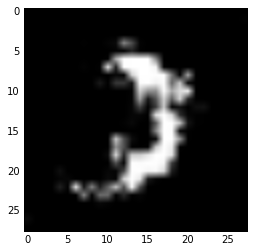

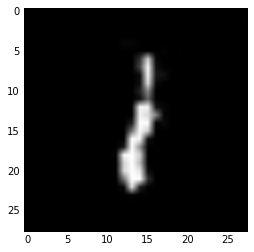

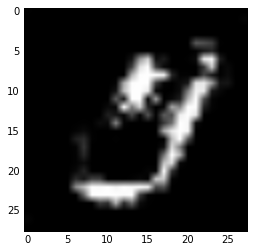

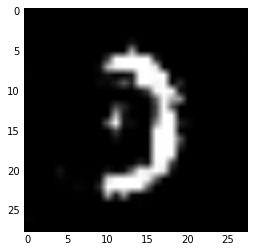

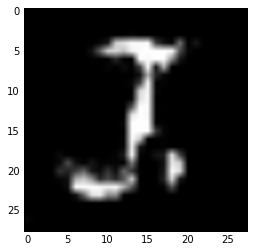

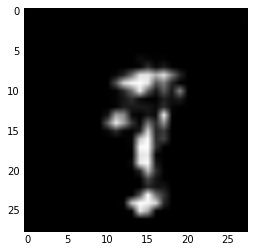

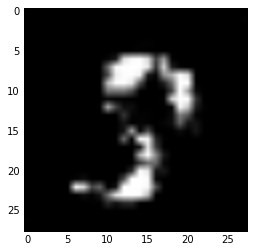

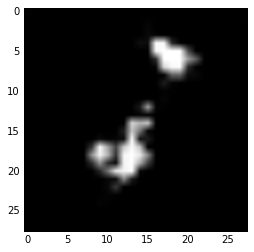

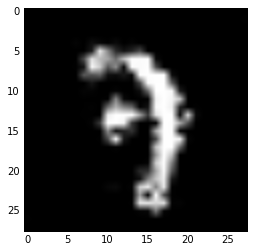

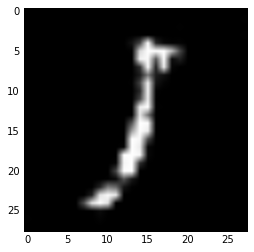

In [10]:
noise = np.random.normal(0.0, 1.0,size=[256,100])
generated_images = G.predict(noise)
for i in range(10):    
    pixels =generated_images[i]
    pixels = pixels.reshape((28, 28))
    # Plot
    plt.imshow(pixels, cmap='gray')
    plt.show()

Sources: 
1. https://adeshpande3.github.io/adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html
2. http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/
3. https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
4. http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/